In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from scipy.interpolate import interp1d

R_sun = 6.957e10

In [2]:
def read_solar_S_hdf5(file_path):
    with h5py.File(file_path, 'r') as f:
        r_over_R = np.array(f['/r_over_R'])
        c_s = np.array(f['/c_s'])
        Gamma_1 = np.array(f['/Gamma_1'])
        T0 = np.array(f['/T'])
        rho0 = np.array(f['/rho'])
        p0 = np.array(f['/p'])
        
        #flipping arrays so they start at r/R = 0 and ends at 1.
        #strictly not necessary for calculations 
        r_over_R = np.flip(r_over_R)
        c_s = np.flip(c_s)
        Gamma_1 = np.flip(Gamma_1)
        T0 = np.flip(T0)
        rho0 = np.flip(rho0)
        p0 = np.flip(p0)

    return r_over_R, c_s, Gamma_1, T0, rho0, p0

r_over_R_raw, c_s_raw, Gamma_1_raw, T0_raw, rho0_raw, p0_raw\
    =read_solar_S_hdf5("../../additional_files/solar_s.h5")

In [18]:
def get_interpolated_vars(kind_, nz):
    # Create interpolated functions
    c_s_interp = interp1d(r_over_R_raw, c_s_raw, kind=kind_) # Change kind if needed
    Gamma_1_interp = interp1d(r_over_R_raw, Gamma_1_raw, kind=kind_)
    T0_interp = interp1d(r_over_R_raw, T0_raw, kind=kind_)
    rho0_interp = interp1d(r_over_R_raw, rho0_raw, kind=kind_)
    p0_interp = interp1d(r_over_R_raw, p0_raw, kind=kind_)

    r_over_R_interp = np.linspace(0.1001302,0.95, nz)
    c_s_interp = c_s_interp(r_over_R_interp)
    Gamma_1_interp = Gamma_1_interp(r_over_R_interp)
    T0_interp = T0_interp(r_over_R_interp)
    rho0_interp = rho0_interp(r_over_R_interp)
    p0_interp = p0_interp(r_over_R_interp)
    
    return r_over_R_interp, c_s_interp, Gamma_1_interp, T0_interp, rho0_interp, p0_interp

In [4]:
def get_H(r_over_R, p0):
    H = - R_sun*p0*(np.roll(r_over_R,-1)-r_over_R)/(np.roll(p0,-1)-p0)
    return H

In [5]:
def get_superad_param(p0, T0):
    return -0.4 + p0/T0 * (np.roll(T0,-1)-T0)/(np.roll(p0,-1)-p0)

In [11]:
def get_c_p(p0, rho0, T0, Gamma_1):
    r_star = p0 / (rho0 * T0)
    c_p = r_star / (1 - 1/Gamma_1)
    return c_p

In [ ]:
plt.plot(r_over_R_raw[raw_mask], get_c_p(p0_raw, rho0_raw, T0_raw, Gamma_1_raw)[raw_mask])
plt.plot(r_over_R_interp, get_c_p(p0_interp, rho0_interp, T0_interp, Gamma_1_interp))

In [6]:
def get_RHS(r_over_R, rho0, p0, T0, Gamma_1):
    superad_param = get_superad_param(p0, T0)
    H = get_H(r_over_R, p0)
    
    c_p = get_c_p(p0, rho0, T0, Gamma_1)
    RHS = -(c_p / H) * superad_param
    return RHS

In [ ]:
plt.plot(r_over_R_raw[raw_mask], get_RHS(r_over_R_raw, rho0_raw, p0_raw, T0_raw, Gamma_1_raw)[raw_mask])
plt.plot(r_over_R_interp[:-1], get_RHS(r_over_R_interp, rho0_interp, p0_interp, T0_interp, Gamma_1_interp)[:-1])

In [44]:
def get_entropy(r_over_R, p0, T0, rho0, Gamma_1):
    r_star = p0 / (rho0 * T0)    
    RHS = get_RHS(r_over_R, rho0, p0, T0, Gamma_1)
    
    s0 = np.zeros(len(T0))
    #s0[0] = r_star[0] / (1 - 1/Gamma_1[0])
    R = 8.314 #ideal gas constant
    
    s0[0] = 8.314 * 5/2 #here I set the reference value of entropy s0[0]=c_pr (is this okay?)
    for i in range(1,len(T0)):
        dz = R_sun * (r_over_R[i] - r_over_R[i-1]);
        s0[i] = s0[i-1] + 0.5*(RHS[i]-RHS[i-1]) * dz;
    
    return s0

In [21]:
p0_raw[raw_mask].shape

(1114,)

In [45]:
nz = int(1e5)

r_over_R_interp, c_s_interp, Gamma_1_interp, T0_interp, rho0_interp, p0_interp = get_interpolated_vars("linear", nz)
superad_param_lin = get_superad_param(p0_interp, T0_interp)
H_lin = get_H(r_over_R_interp, p0_interp)
s0_lin = get_entropy(r_over_R_interp, p0_interp, T0_interp, rho0_interp, Gamma_1_interp)
rhs_lin = get_RHS(r_over_R_interp, rho0_interp, p0_interp, T0_interp, Gamma_1_interp)

r_over_R_interp, c_s_interp, Gamma_1_interp, T0_interp, rho0_interp, p0_interp = get_interpolated_vars("cubic", nz)
superad_param_cub = get_superad_param(p0_interp, T0_interp)
H_cub = get_H(r_over_R_interp, p0_interp)
s0_cub = get_entropy(r_over_R_interp, p0_interp, T0_interp, rho0_interp, Gamma_1_interp)
rhs_cub = get_RHS(r_over_R_interp, rho0_interp, p0_interp, T0_interp, Gamma_1_interp)

r_over_R_interp, c_s_interp, Gamma_1_interp, T0_interp, rho0_interp, p0_interp = get_interpolated_vars("quadratic", nz)
superad_param_quad = get_superad_param(p0_interp, T0_interp)
H_quad = get_H(r_over_R_interp, p0_interp)
s0_quad = get_entropy(r_over_R_interp, p0_interp, T0_interp, rho0_interp, Gamma_1_interp)
rhs_quad = get_RHS(r_over_R_interp, rho0_interp, p0_interp, T0_interp, Gamma_1_interp)

raw_mask = (r_over_R_raw > 0.1) & (r_over_R_raw < 0.95)

superad_param_raw = get_superad_param(p0_raw[raw_mask], T0_raw[raw_mask])
H_raw = get_H(r_over_R_raw[raw_mask], p0_raw[raw_mask])
s0_raw = get_entropy(r_over_R_raw[raw_mask], p0_raw[raw_mask], T0_raw[raw_mask], rho0_raw[raw_mask], Gamma_1_raw[raw_mask])
rhs_raw = get_RHS(r_over_R_raw[raw_mask], rho0_raw[raw_mask], p0_raw[raw_mask], T0_raw[raw_mask], Gamma_1_raw[raw_mask])

In [30]:
"""
fig, ax = plt.subplots(2,2,figsize=(12,8))

fig.suptitle("nz=10$^2$")
ax[0][0].semilogy(r_over_R_interp[:-1], H_lin[:-1], label="Lin interp", color="black", linestyle="dashdot")
ax[0][0].semilogy(r_over_R_interp[:-1], H_quad[:-1], label="Quad interp", color="green", linestyle="--")
ax[0][0].semilogy(r_over_R_raw[raw_mask][:-1], H_raw[:-1], label="Raw data", color="red", linestyle=":")
ax[0][0].set_xlabel("R/R$_*$")
ax[0][0].set_ylabel("Pressure scale height H")
ax[0][0].legend()

ax[0][1].plot(r_over_R_interp[:-1], superad_param_lin[:-1], label="Lin interp", color="black", linestyle="dashdot")
ax[0][1].plot(r_over_R_interp[:-1], superad_param_quad[:-1], label="Quad interp", color="green", linestyle="--")
ax[0][1].plot(r_over_R_raw[raw_mask][:-1], superad_param_raw[:-1], label="Raw data", color="red", linestyle=":")
ax[0][1].set_xlabel("R/R$_*$")
ax[0][1].set_ylabel(r"Superadiabacicity parameter $\Delta\nabla$")
ax[0][1].legend()

ax[1][0].plot(r_over_R_interp[:-1], s0_lin[:-1], label="Lin interp", color="black", linestyle="dashdot")
ax[1][0].plot(r_over_R_interp[:-1], s0_quad[:-1], label="Quad interp", color="green", linestyle="--")
ax[1][0].plot(r_over_R_raw[raw_mask][:-1], s0_raw[:-1], label="Raw data", color="red", linestyle=":")
ax[1][0].set_xlabel("R/R$_*$")
ax[1][0].set_ylabel("Entropy")
ax[1][0].legend()

ax[1][1].plot(r_over_R_interp[:-1], rhs_lin[:-1], label="Lin interp", color="black", linestyle="dashdot")
ax[1][1].plot(r_over_R_interp[:-1], rhs_quad[:-1], label="Quad interp", color="green", linestyle="--")
ax[1][1].plot(r_over_R_raw[raw_mask][:-1], rhs_raw[:-1], label="Raw data", color="red", linestyle=":")
ax[1][1].set_xlabel("R/R$_*$")
ax[1][1].set_ylabel("RHS Entropy")
ax[1][1].legend()

fig.tight_layout()
#plt.savefig()"""

'\nfig, ax = plt.subplots(2,2,figsize=(12,8))\n\nfig.suptitle("nz=10$^2$")\nax[0][0].semilogy(r_over_R_interp[:-1], H_lin[:-1], label="Lin interp", color="black", linestyle="dashdot")\nax[0][0].semilogy(r_over_R_interp[:-1], H_quad[:-1], label="Quad interp", color="green", linestyle="--")\nax[0][0].semilogy(r_over_R_raw[raw_mask][:-1], H_raw[:-1], label="Raw data", color="red", linestyle=":")\nax[0][0].set_xlabel("R/R$_*$")\nax[0][0].set_ylabel("Pressure scale height H")\nax[0][0].legend()\n\nax[0][1].plot(r_over_R_interp[:-1], superad_param_lin[:-1], label="Lin interp", color="black", linestyle="dashdot")\nax[0][1].plot(r_over_R_interp[:-1], superad_param_quad[:-1], label="Quad interp", color="green", linestyle="--")\nax[0][1].plot(r_over_R_raw[raw_mask][:-1], superad_param_raw[:-1], label="Raw data", color="red", linestyle=":")\nax[0][1].set_xlabel("R/R$_*$")\nax[0][1].set_ylabel(r"Superadiabacicity parameter $\\Delta\nabla$")\nax[0][1].legend()\n\nax[1][0].plot(r_over_R_interp[:-1],

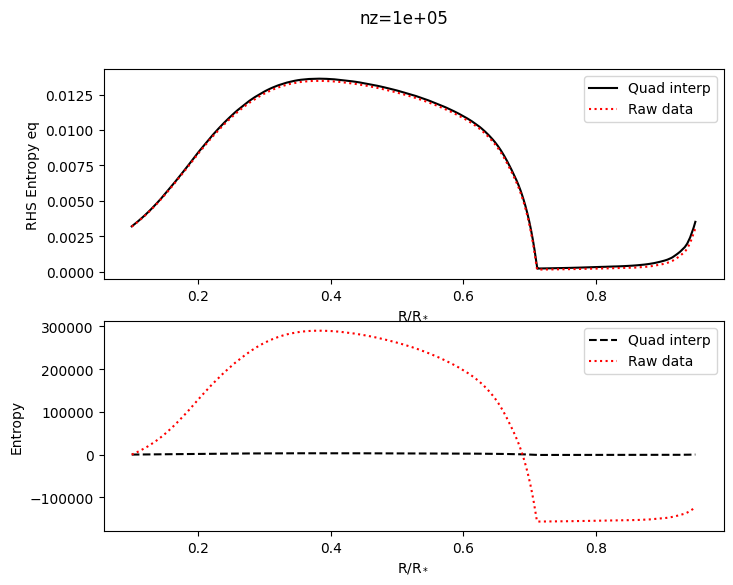

In [46]:
fig, ax = plt.subplots(2,figsize=(8,6))

fig.suptitle("nz={:.0e}".format(nz))

#ax[0].plot(r_over_R_interp[:-1], rhs_lin[:-1], label="Lin interp", color="blue", linestyle="dashdot")
ax[0].plot(r_over_R_interp[:-1], rhs_quad[:-1], label="Quad interp", color="black", linestyle="-")
ax[0].plot(r_over_R_raw[raw_mask][:-1], rhs_raw[:-1], label="Raw data", color="red", linestyle=":")
ax[0].set_xlabel("R/R$_*$")
ax[0].set_ylabel("RHS Entropy eq")
ax[0].legend()

#ax[1].plot(r_over_R_interp[:-1], s0_lin[:-1], label="Lin interp", color="black", linestyle="dashdot")
ax[1].plot(r_over_R_interp[:-1], s0_quad[:-1], label="Quad interp", color="black", linestyle="--")
ax[1].plot(r_over_R_raw[raw_mask][:-1], s0_raw[:-1], label="Raw data", color="red", linestyle=":")
ax[1].set_xlabel("R/R$_*$")
ax[1].set_ylabel("Entropy")
ax[1].legend()

In [ ]:
fig, ax = plt.subplots(figsize=(7,4))

ax.semilogy(r_over_R_interp[:-1], s0_lin[:-1], label="linear", color="black")
ax.semilogy(r_over_R_interp[:-1], s0_quad[:-1], label="quadratic", color="blue")
ax.semilogy(r_over_R_interp[:-1], s0_cub[:-1], label="cubic", color="red")
ax.semilogy(r_over_R_raw[raw_mask], s0_raw[raw_mask], label="Raw data", color="green")
ax.set_xlabel("R/R$_*$")
ax.set_ylabel("Entropy")
ax.legend()

In [ ]:
def plot_of_kind(kind_):
    #kind_ = "linear"
    # Create interpolated functions
    c_s_interp = interp1d(r_over_R, c_s, kind=kind_) # Change kind if needed
    Gamma_1_interp = interp1d(r_over_R, Gamma_1, kind=kind_)
    T0_interp = interp1d(r_over_R, T0, kind=kind_)
    rho0_interp = interp1d(r_over_R, rho0, kind=kind_)
    p0_interp = interp1d(r_over_R, p0, kind=kind_)

    r_over_R_interp = np.linspace(0.2,0.95, int(1e4))
    c_s_interp = c_s_interp(r_over_R_interp)
    Gamma_1_interp = Gamma_1_interp(r_over_R_interp)
    T0_interp = T0_interp(r_over_R_interp)
    rho0_interp = rho0_interp(r_over_R_interp)
    p0_interp = p0_interp(r_over_R_interp)
    
    R_sun = 6.957e10
    H_on_interpolated = - (np.roll(r_over_R_interp,-1)-r_over_R_interp)*R_sun\
                      / (np.roll(np.log(p0_interp),-1)-np.log(p0_interp))
    
    plt.plot(r_over_R_interp, H_on_interpolated, label=kind_)

In [ ]:
plot_of_kind("linear")
plot_of_kind("cubic")
#plot_of_kind("quadratic")
plt.legend()
plt.xlim(0.3,0.4)
plt.ylim(4.8e9, 5e9)
plt.xlabel("R/R$_*$")
plt.ylabel("Pressure scale height H")

In [ ]:
kind_ = "linear"
# Create interpolated functions
c_s_interp = interp1d(r_over_R, c_s, kind=kind_)
Gamma_1_interp = interp1d(r_over_R, Gamma_1, kind=kind_)
T0_interp = interp1d(r_over_R, T0, kind=kind_)
rho0_interp = interp1d(r_over_R, rho0, kind=kind_)
p0_interp = interp1d(r_over_R, p0, kind=kind_)

r_over_R_interp = np.linspace(0.2,0.95, int(1e4))
c_s_interp = c_s_interp(r_over_R_interp)
Gamma_1_interp = Gamma_1_interp(r_over_R_interp)
T0_interp = T0_interp(r_over_R_interp)
rho0_interp = rho0_interp(r_over_R_interp)
p0_interp = p0_interp(r_over_R_interp)

In [ ]:
plt.plot(r_over_R_interp, p0_interp)
plt.plot(r_over_R, p0, linestyle=":")

In [ ]:
H_on_raw_data = - (np.roll(r_over_R,-1)-r_over_R)*R_sun * p0 / (np.roll(p0,-1)-p0)

In [ ]:
plt.plot(r_over_R_interp[:-1], H_on_interpolated[:-1], label="Interpolated data")

In [ ]:
plt.plot(r_over_R_interp[1000:-1], H_on_interpolated[1000:-1], label="Interpolated data")
plt.plot(r_over_R[500:1200], H_on_raw_data[500:1200], label="Raw data")
plt.xlabel("R/R$_*$")
plt.ylabel("Pressure scale height")
plt.xlim(0.4,0.5)
plt.legend()

In [48]:
nz = 10
for j in range(0, nz):
    i= nz-1-j
    print(i)

9
8
7
6
5
4
3
2
1
0
